# Statistical Pattern Recognition - Exercise 6: Gaussian processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
from functools import partial


## Define plot function 

We test it on [this example from sklearn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

To plot the 95% confidence interval we look up the z-score for the standard normal distribution.
Assume a standard normal with mean 0, std 1, then for input value x=1.96 the cumulative density is 0.975.
This means 97.5% of all probability mass is to the left of x.
If we now cut off left of -1.96 and right of 1.96 we will have 95% of the probability mass inside those boundaries.

```python
# import scipy.stats
# z_score = stats.norm.ppf(0.975)  # ~1.96
```

Ppf here means percent-point function (inverse of the cumulative density function or CDF) for a standard normal distribution.


In [2]:
def plot_gp(mu, cov, x, x_train=None, y_train=None, label="Pred"):
    """
        mu: mean prediction, shape (N, 1)
        cov: prediction covariance, shape (N, N)
        x: inputs to predict for, shape (N, 1)
        x_train: observation inputs, shape (N_obs, 1)
        y_train: obersvation labels, shape (N_obs,)
    """
    x, mu = x.ravel(), mu.ravel()  # flatten both to shape (N, )
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.fill_between(x, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(x, mu, label=label)

    if x_train is not None:
        n_samples = x_train.shape[0]
        plt.plot(x_train, y_train, "rx", label=f"{n_samples} train samples")
    plt.legend()


gaussian_process.kernel_=1**2 * RBF(length_scale=1)


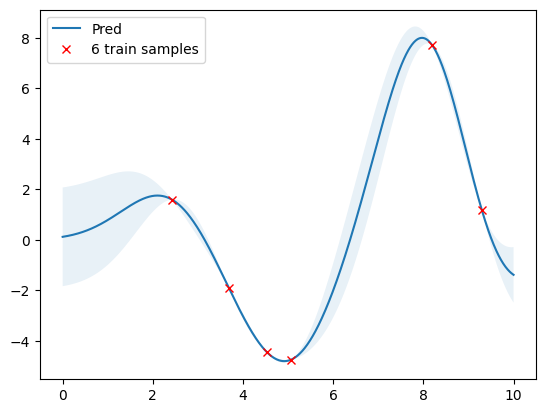

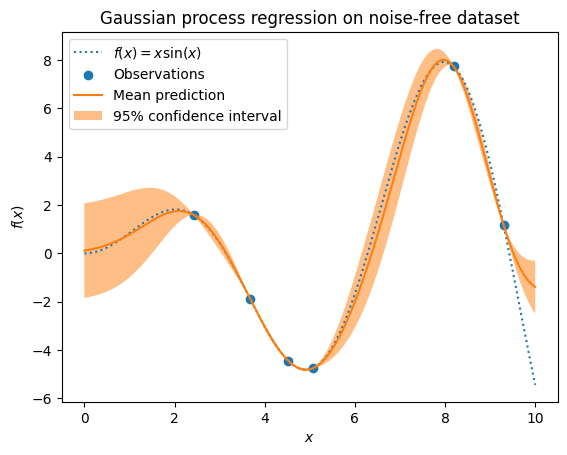

In [3]:
# run the gp example from sklearn
e_x = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
e_y = np.squeeze(e_x * np.sin(e_x))
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(e_y.size), size=6, replace=False)
e_x_train, e_y_train = e_x[training_indices], e_y[training_indices]
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gaussian_process.fit(e_x_train, e_y_train)
print(f"{gaussian_process.kernel_=}")

# run our plot code
mu, cov = gaussian_process.predict(e_x, return_cov=True)
plot_gp(mu, cov, e_x, e_x_train, e_y_train)
plt.show()

# compare with sklearn's plot code
mean_prediction, std_prediction = gaussian_process.predict(e_x, return_std=True)
plt.plot(e_x, e_y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(e_x_train, e_y_train, label="Observations")
plt.plot(e_x, mean_prediction, label="Mean prediction")
plt.fill_between(
    e_x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on noise-free dataset")
plt.show()


## $\star$ Part 1: Gaussian process

### Part 1.1: Run a Gaussian Process Regressor using sklearn

Load the points from regression.npz. 

Estimate the mean prediction and the variance using a Gaussian process and plot both in the style of last week’s assignment. Use a RBF kernel (a Gaussian function) scaled by a parameter $\sigma^2$.
 
Play with the hyperparameters (which hyperparameters do you have?) and see the effect in the predictive distribution. 

Reduce the number of samples and repeat the experiments.


In [4]:
# START TODO ################
# Load data and reshape it into X_train shape (N, 1) and Y_train shape (N,)
# Create a suitable range X_test for testing
data = np.load("../data/regression.npz")
train_samples = data["arr_0"]
print(f"Data shape: {train_samples.shape}")

x_train = train_samples[:, 0].reshape(-1, 1)
y_train = train_samples[:, 1]  # .reshape(-1, 1)
x_min, x_max = np.min(x_train), np.max(x_train)

x_test = np.linspace(x_min-0.1, x_max+0.1, 500, endpoint=True).reshape(-1, 1)
# END TODO ################


Data shape: (20, 2)


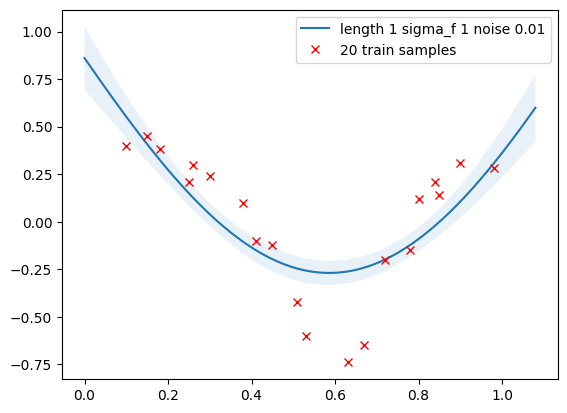

In [5]:
# START TODO ################
# Create a function that fits a GP using sklearn and plots it.
# Return mean and covariance. Run the function on the data.

def get_rbf_kernel(length=1, sigma_f=1):
    return ConstantKernel(sigma_f**2, constant_value_bounds="fixed") * RBF(
        length_scale=length, length_scale_bounds="fixed")


def GP_SCI(x_test, x_train, y_train, length=1, sigma_f=1, noise=1e-2, plot_train_points=True):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    """
    rbf = get_rbf_kernel(length=length, sigma_f=sigma_f)
    gp = GaussianProcessRegressor(kernel=rbf, optimizer=None, alpha=noise)
    gp.fit(x_train, y_train)
    mu, cov = gp.predict(x_test, return_cov=True)
    label=f"length {length} sigma_f {sigma_f} noise {noise}"
    if plot_train_points:
        plot_gp(mu, cov, x_test, x_train=x_train, y_train=y_train, label=label)
    else:
        plot_gp(mu, cov, x_test, label=label)
    return mu, cov
    
GP_SCI(x_test, x_train, y_train)
pass
# END TODO ################


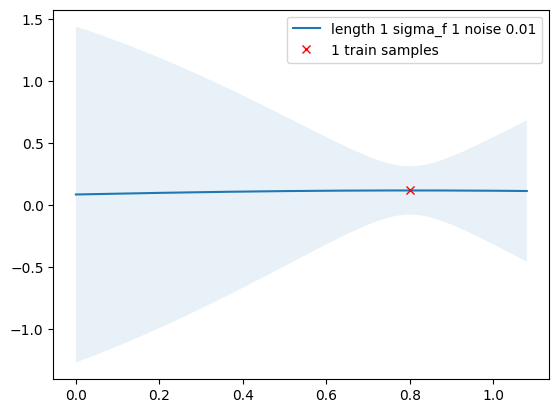

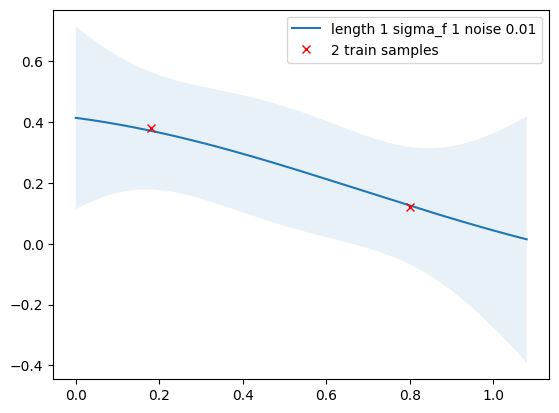

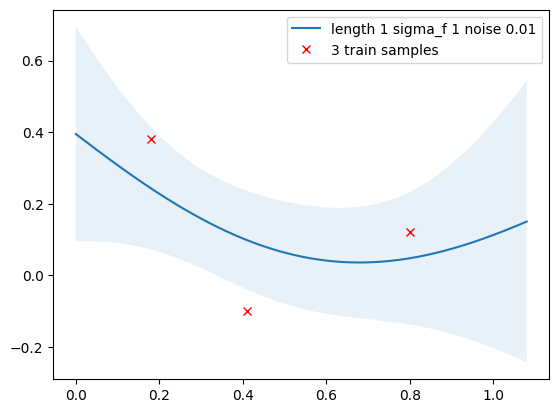

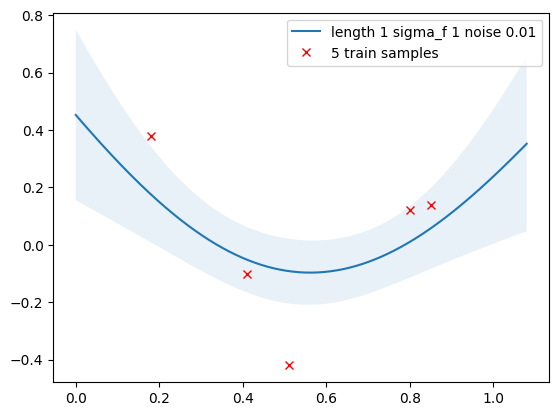

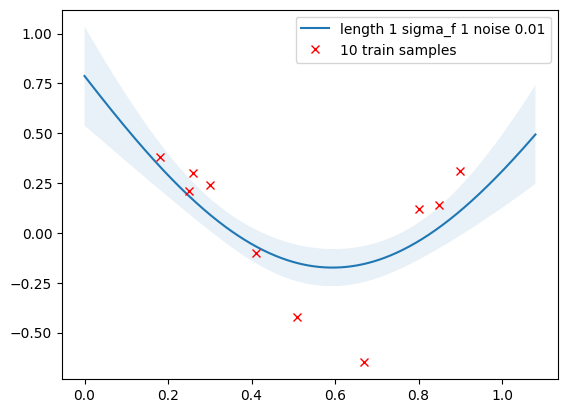

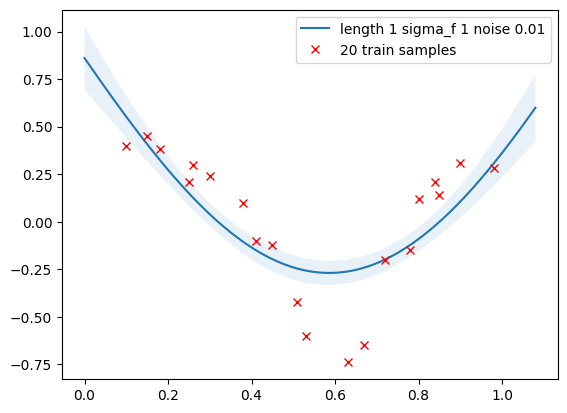

In [6]:
# START TODO ################
# Randomly subsample your data and run the GP on [1, 2, 3, 5, 10, 20] datapoints.
# What do you observe?
indices = np.arange(len(x_train))
np.random.seed(42)
np.random.shuffle(indices)

for n in [1, 2, 3, 5, 10, 20]:
    indices_here = indices[:n]
    GP_SCI(x_test, x_train[indices_here], y_train[indices_here], noise=1e-2)
    plt.show()

# Observation: The uncertainty quickly goes down with a few samples
# END TODO ################


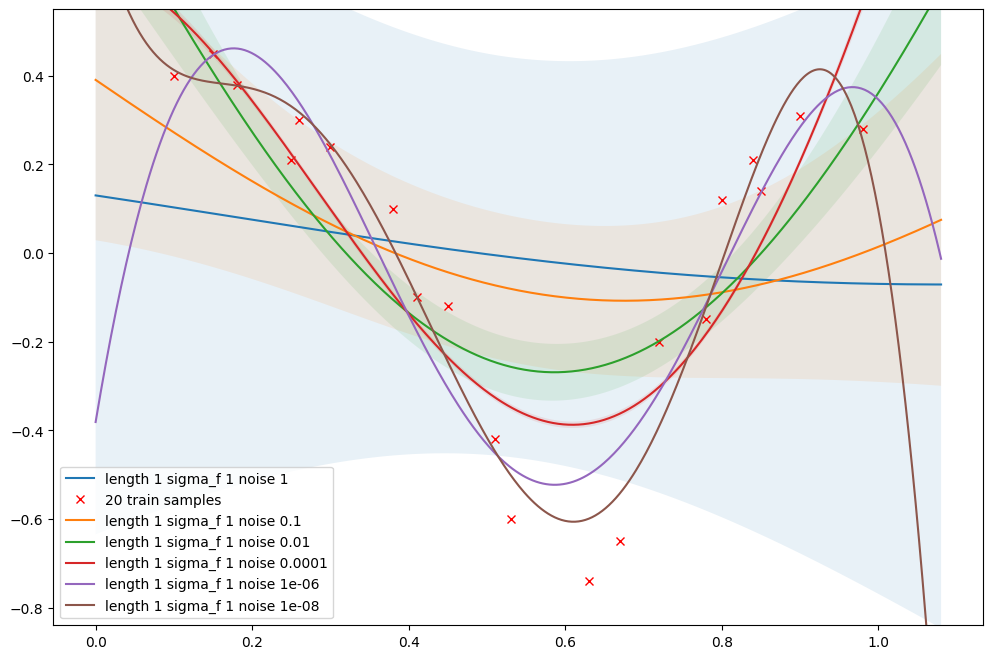

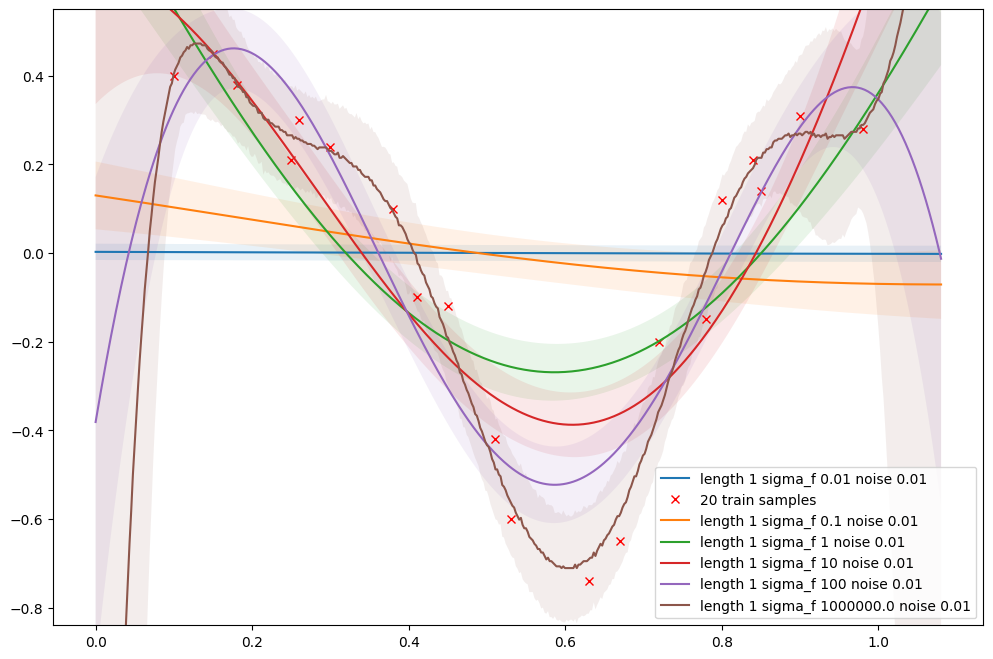

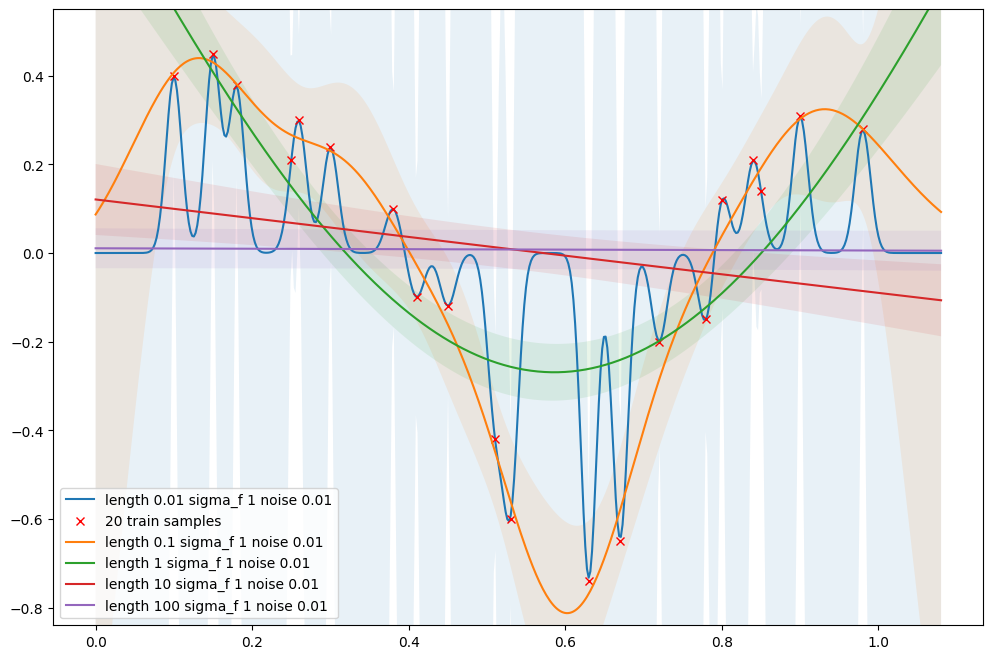

In [7]:
# START TODO ################
# Go back to the full dataset and play with the other hyperparameters.

y_min, y_max = np.min(y_train) - 0.1, np.max(y_train + 0.1)

# Modify the noise.
# Observation: Too high noise gives a flat prediction that ignores the data.
# Too low noise produces overfitting.
plt.figure(figsize=(12, 8))
for i, noise in enumerate([1, 1e-1, 1e-2, 1e-4, 1e-6, 1e-8]):
    GP_SCI(x_test, x_train, y_train, noise=noise, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# Modify sigma_f
# Observation: sigma_f weights your kernel. Very low values means your kernel
# has no weight and the prediction is always 0.
# High values gives very high weight to the kernel and leads to overfitting.
plt.figure(figsize=(12, 8))
for i, sigma_f in enumerate([0.01, 0.1, 1, 10, 100, 1e6]):
    GP_SCI(x_test, x_train, y_train, sigma_f=sigma_f, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# Modify length
# Observation: Length determines how far your kernel reaches. High values
# gives very flat kernels and leads to predicting zero everywhere.
# Low values leads to exactly predicting the datapoints and zero everywhere else.
plt.figure(figsize=(12, 8))
for i, length in enumerate([0.01, 0.1, 1, 10, 100]):
    GP_SCI(x_test, x_train, y_train, length=length, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# END TODO ################


### Part 1.2: Now, implement your own rbf_kernel function and MyGPRegressor class.



*Solution:*

The RBF kernel on two samples $\mathbf{x}\in \mathbb{R}^{k}$ and $\mathbf{x'}$, represented as feature vectors in some input space, is defined as ([Wikipedia Source](https://en.wikipedia.org/w/index.php?title=Radial_basis_function_kernel))

$K(\mathbf{x}, \mathbf{x'}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{x'}\|^2}{2\sigma^2}\right)$

The length scale $l$ determines how quickly the correlation between points decays with distance.
In other words, it determines the length of the 'wiggles' in your function.
In general, you won't be able to extrapolate more than ℓ units away from your data.

Then, the kernel function is multiplied by $\sigma^2$.
The output variance $\sigma^2$ determines the average distance of your function away from its mean.
Every kernel has this parameter out in front; it's just a scale factor.

[Source](https://www.cs.toronto.edu/~duvenaud/cookbook/)

The implementation of the GP is given by slides 14 ff (Gaussian processes for modeling given data).


In [8]:
# START TODO ################
# Now, implement your own rbf_kernel function and MyGPRegressor class.

def rbf_kernel(X1, X2, length=1, sigma_f=1):
    """
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
    Returns:
        (m x n) matrix.
    """
    # Note this is an effcient way to compute pairwise distances.
    # It uses the identity (a-b)^2 = a^2 + b^2 - 2ab
    # Alternatively you can use:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
    # which does the same thing
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length**2 * sqdist)

# verify the implementation
kernel1 = get_rbf_kernel(length=2, sigma_f=5)
kernel2 = partial(rbf_kernel, length=2, sigma_f=5)
x1 = np.random.randn(100, 10)
x2 = np.random.randn(100, 10)
np.testing.assert_allclose(kernel1(x1, x2), kernel2(x1, x2))


class MyGPRegressor:
    def __init__(self, kernel_fn, beta=100, **kernel_kwargs):
        self.kernel_func = partial(kernel_fn, **kernel_kwargs)
        self.beta_inv = 1 / beta

    def fit(self, X_train, Y_train):
        """
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        """
        self.C_n = self.kernel_func(X_train, X_train) + self.beta_inv * np.eye(len(X_train))
        self.iC_n = np.linalg.inv(self.C_n)
        self.X_train = X_train
        self.Y_train = Y_train

    def predict(self, X_n):
        X_n = X_n.reshape(-1, 1)
        c = self.kernel_func(X_n, X_n) + self.beta_inv * np.eye(len(X_n))
        k = self.kernel_func(self.X_train, X_n)

        mu = k.T.dot(self.iC_n).dot(self.Y_train)
        sigma = c - k.T.dot(self.iC_n).dot(k)
        return mu, sigma
# END TODO ################


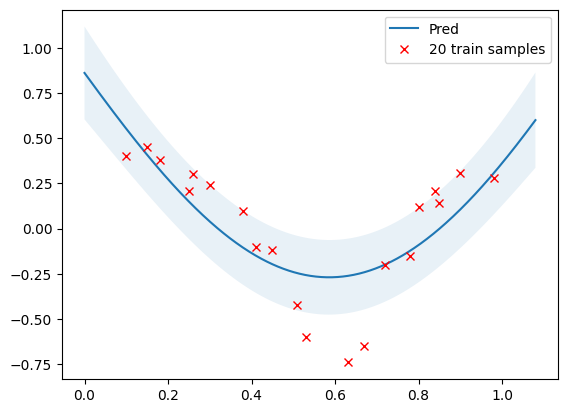

In [9]:
# START TODO ################
# Run your implementation on the data.
gp = MyGPRegressor(rbf_kernel, beta=100)
gp.fit(x_train, y_train)
mu_test, sigma_test = gp.predict(x_test)

plot_gp(
    mu_test,
    sigma_test,
    x_test,
    x_train=x_train,
    y_train=y_train,
)
plt.show()
# END TODO ################


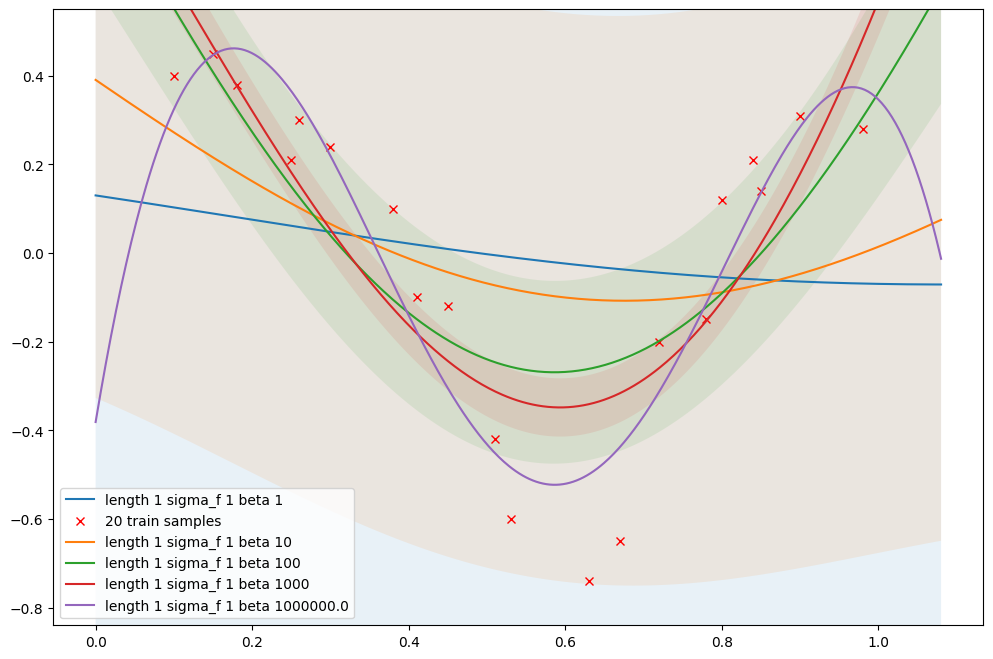

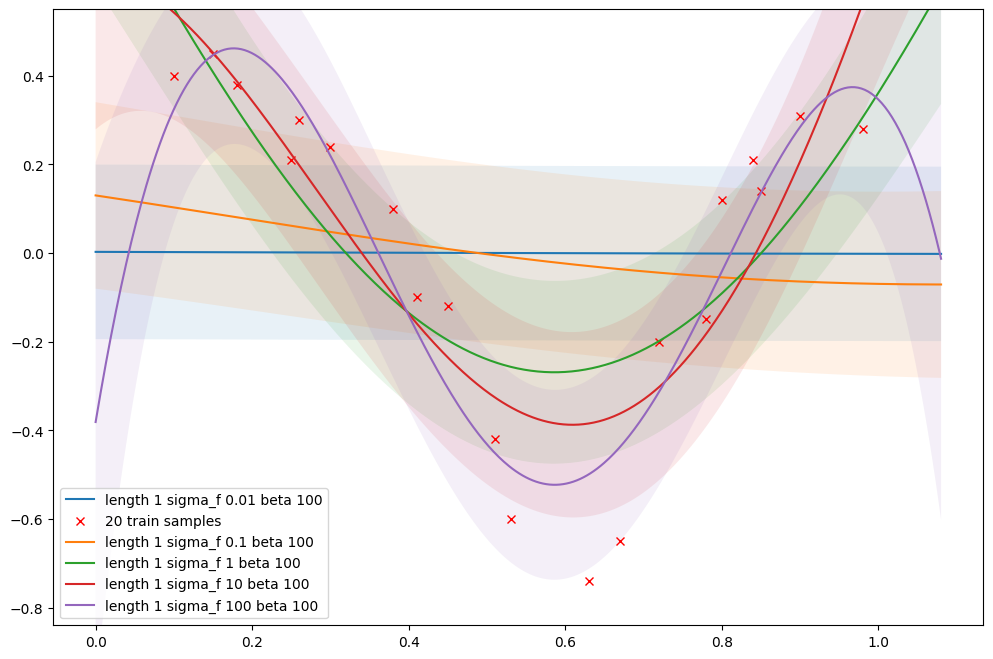

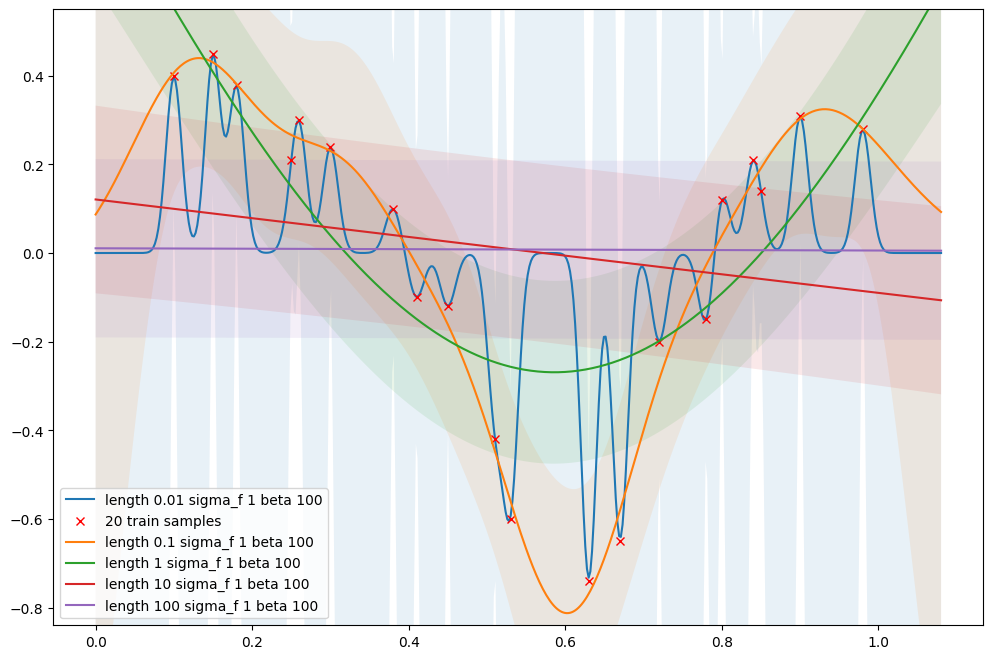

In [10]:
# START TODO ################
# Play with the beta parameter of MyGPRegressor and also length and sigma_f parameters of rbf_kernel
# Observe how these *hyperparameters* change the data fit. Try to reason why you obtain these different results.

from functools import partial

def gp_ours(x_test, x_train, y_train, length=1, sigma_f=1, beta=100, plot_train_points=True):
    rbf_kernel_here = partial(rbf_kernel, length=length, sigma_f=sigma_f)
    gp = MyGPRegressor(rbf_kernel_here, beta=beta)
    gp.fit(x_train, y_train)
    mu, cov = gp.predict(x_test)
    # print(mu.shape, sigma.shape, x_test.shape)
    label=f"length {length} sigma_f {sigma_f} beta {beta}"
    if plot_train_points:
        plot_gp(mu, cov, x_test, x_train=x_train, y_train=y_train, label=label)
    else:
        plot_gp(mu, cov, x_test, label=label)

y_min, y_max = np.min(y_train) - 0.1, np.max(y_train + 0.1)

# Modify beta.
# Observation: Low beta leads to high uncertainty and flat predictions.
plt.figure(figsize=(12, 8))
for i, beta in enumerate([1, 10, 100, 1000, 1e6]):
    gp_ours(x_test, x_train, y_train, beta=beta, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# Modify sigma_f
plt.figure(figsize=(12, 8))
for i, sigma_f in enumerate([0.01, 0.1, 1, 10, 100]):
    gp_ours(x_test, x_train, y_train, sigma_f=sigma_f, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# Modify length
plt.figure(figsize=(12, 8))
for i, length in enumerate([0.01, 0.1, 1, 10, 100]):
    gp_ours(x_test, x_train, y_train, length=length, plot_train_points=i==0)
plt.ylim([y_min, y_max])
plt.show()

# END TODO ################


### Part 1.3: Compare your GP and the sklearn GP (Bonus)

Hint: sklearn uses the algorithm 2.1 from the GPML book: 

https://gaussianprocess.org/gpml/


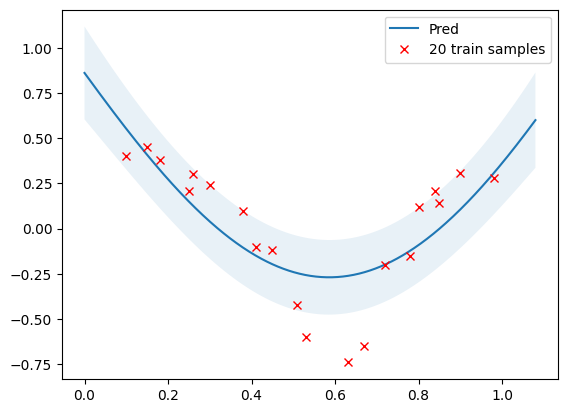

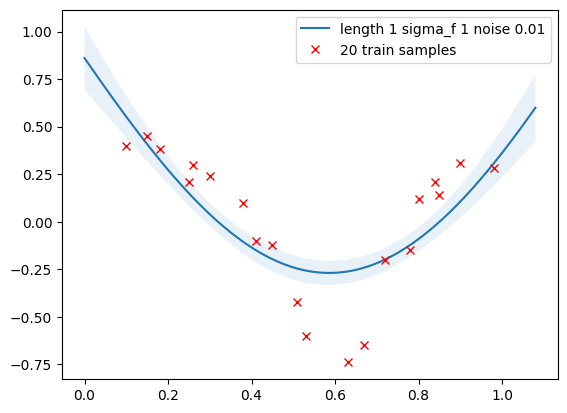

In [11]:
# START TODO ################
# Use a kernel with length=1, sigma_f=1
# Plot your GP with beta=100 and the sklearn GP with noise=0.01
# Compare the plots.
#
# If you have implemented your own algorithm with the formula
# given by the slides, you will find that the uncertainty is 
# higher for your GP. Why?

# Compare our regressor and sklearn
gp = MyGPRegressor(rbf_kernel, beta=100)
gp.fit(x_train, y_train)
mu_test, sigma_test = gp.predict(x_test)
plot_gp(mu_test, sigma_test, x_test, x_train=x_train, y_train=y_train)
plt.show()

GP_SCI(x_test, x_train, y_train, noise=1e-2)
plt.show()

# END TODO ################


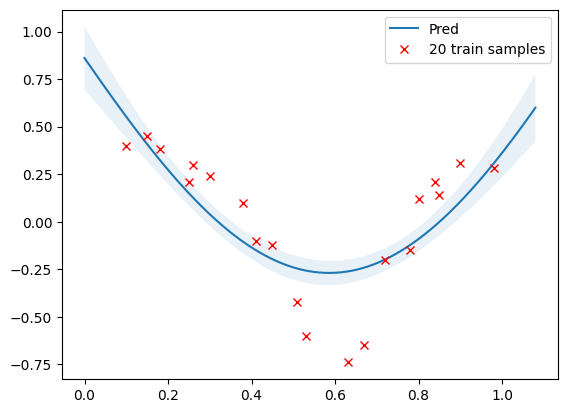

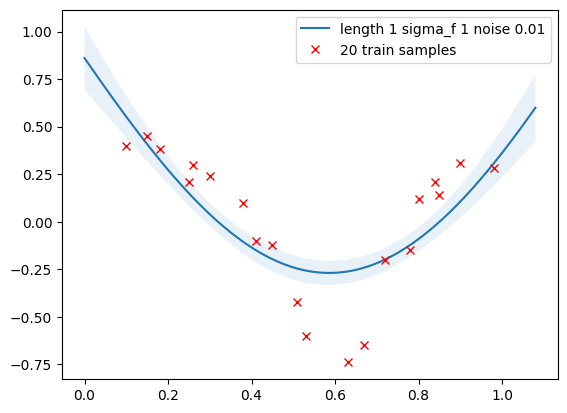

In [12]:
# START TODO ################
# Once you have figured out why the uncertainty is different, 
# change your plots such that they are the same.

# Solution: The sklearn algorithm returns the variance for noise-free test points.
# The algorithm from the slides returns the variance for noisy test points.
# So if you subtract the noise from the variance return by your implementation
# you will get the same plots.

gp = MyGPRegressor(rbf_kernel, beta=100)
gp.fit(x_train, y_train)
mu_test, sigma_test = gp.predict(x_test)
# subtract noise to simulate noise-free datapoints
sigma_test = sigma_test - np.eye(sigma_test.shape[0]) * 1/100
plot_gp(mu_test, sigma_test, x_test, x_train=x_train, y_train=y_train)
plt.show()

mu_test_sci, sigma_test_sci = GP_SCI(x_test, x_train, y_train, noise=1e-2)
plt.show()

np.testing.assert_allclose(mu_test, mu_test_sci)
np.testing.assert_allclose(sigma_test, sigma_test_sci, rtol=1e-4)
# END TODO ################


### Part 1.4: Implement the algorithm 2.1 from the GPML book

https://gaussianprocess.org/gpml/


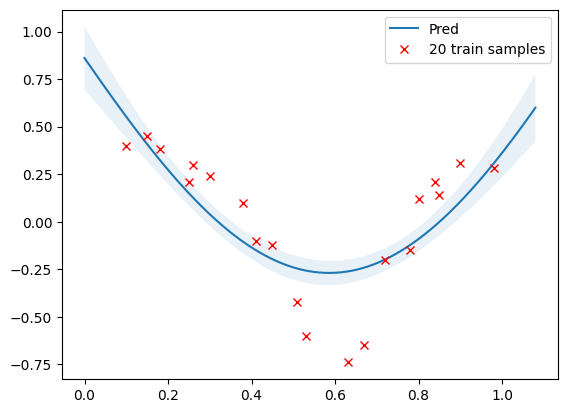

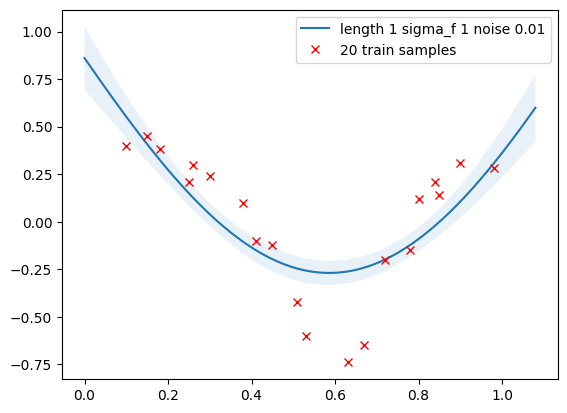

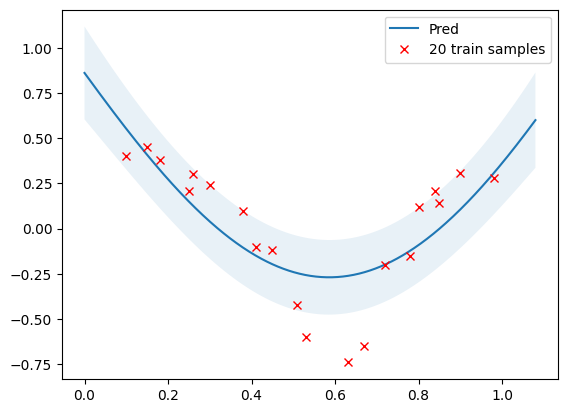

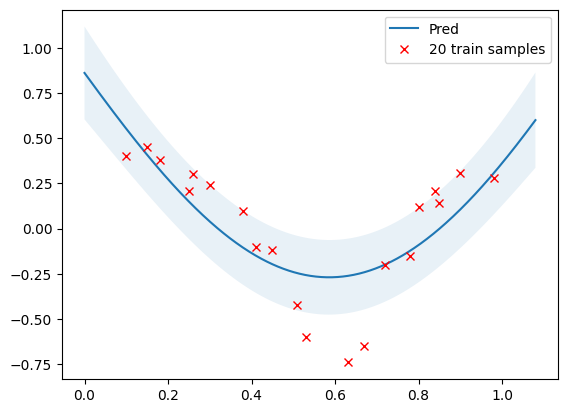

In [13]:
# START TODO ################
# Implement the algorithm 2.1 instead of the one from the slides.
# Note that you can use np.linalg.cholesky and scipy.linalg.solve_triangular
# Verify your implementation by comparing it to one of the algorithms
# implemented before.
from scipy.linalg import solve_triangular


class MyGPRegressorCholesky:
    def __init__(self, kernel_fn, noise=0.01, **kernel_kwargs):
        self.kernel_func = partial(kernel_fn, **kernel_kwargs)        
        self.noise = noise

    def fit(self, X_train, Y_train):
        """
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        """
        K = self.kernel_func(X_train, X_train)
        chol = K + self.noise * np.eye(K.shape[0])
        L = np.linalg.cholesky(chol)
        # L is now a lower triangular s.t. LL^T = chol
        # now we need to find x = L\y (the solution to Lx = y)
        # the triangular matrix allows a very fast solution
        ly = solve_triangular(L, Y_train, lower=True)
        self.alpha = solve_triangular(L.T, ly, lower=False)
        self.L = L
        self.X_train = X_train
        self.Y_train = Y_train

    def predict(self, X_n):
        X_n = X_n.reshape(-1, 1)
        n = X_n.shape[0]
        kstar = self.kernel_func(self.X_train, X_n)
        mu = kstar.T @ self.alpha
        k_xn_xn = self.kernel_func(X_n, X_n)
        v = solve_triangular(self.L, kstar, lower=True)
        sigma = k_xn_xn - v.T @ v
        return mu, sigma

length = 1
sigma_f = 1
noise = 1e-2

# Compare the implementation and the one from sklearn
gp_c = MyGPRegressorCholesky(rbf_kernel, noise=noise, length=length, sigma_f=sigma_f)
gp_c.fit(x_train, y_train)
mu_test_c, sigma_test_c = gp_c.predict(x_test)
plot_gp(mu_test_c, sigma_test_c, x_test, x_train=x_train, y_train=y_train)
plt.show()

mu_test_sk, sigma_test_sk = GP_SCI(
    x_test, x_train, y_train, noise=noise, length=length, sigma_f=sigma_f
)
plt.show()

np.testing.assert_allclose(mu_test_c, mu_test_sk)
np.testing.assert_allclose(np.diag(sigma_test_c), np.diag(sigma_test_sk))

# Compare the first and the second implementation 
# Since algorithm 2.1 returns variance for noise-free test points
# we need to add the noise on top to get the same variance
# as we get for the first implementation based on the slides
# which assums noisy test inputs.
gp_c = MyGPRegressorCholesky(rbf_kernel, noise=noise, length=length, sigma_f=sigma_f)
gp_c.fit(x_train, y_train)
mu_test_c, sigma_test_c = gp_c.predict(x_test)
sigma_test_c_plus_noise = sigma_test_c + np.eye(sigma_test_c.shape[0]) * noise
plot_gp(mu_test_c, sigma_test_c_plus_noise, x_test, x_train=x_train, y_train=y_train)
plt.show()

gp = MyGPRegressor(rbf_kernel, beta=1/noise, length=length, sigma_f=sigma_f)
gp.fit(x_train, y_train)
mu_test, sigma_test = gp.predict(x_test)
plot_gp(mu_test, sigma_test, x_test, x_train=x_train, y_train=y_train)
plt.show()

np.testing.assert_allclose(mu_test_c, mu_test)
np.testing.assert_allclose(np.diag(sigma_test_c_plus_noise), np.diag(sigma_test))

# END TODO ################
